<a href="https://colab.research.google.com/github/masta-g3/robinmodel/blob/main/custom_feats.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# *#FinRes:* Predicting Stock Returns with Custom Features

On this second installment of the *#FinRes* series I continue with the quest of predicting positive stock returns via machine learning methods.

On the last post I tried building two predictive models (Random Forest and XGBoost) that leveraged 77 technical indicators, plus some derived measures of them (rate of change, volatility, etc.) to predict the next day return direction.

In [3]:
!pip install yfinance >> /dev/null
!pip install mplcyberpunk >> /dev/null
!pip install pykalman >> /dev/null
print('Done with installs.')

Done with installs.


In [19]:
import yfinance as yf
import pandas as pd
import numpy as np
from scipy import stats
import warnings

import matplotlib.pyplot as plt
import seaborn as sns
import mplcyberpunk

from pykalman import KalmanFilter
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve

warnings.filterwarnings('ignore')
plt.style.use("cyberpunk")
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [5]:
## Custom function.
def rank(array):
    s = pd.Series(array)
    return s.rank(ascending=False)[len(s)-1]

## Prices

In [134]:
## Ticker data.
ticker = 'AMD'
stock = yf.Ticker(ticker)
stock_df = stock.history(start='2020-01-01', end='2021-01-01')

## Smooth series.
smoother = KalmanFilter(transition_matrices = [1],
              observation_matrices = [1],
              initial_state_mean = stock_df.iloc[0]['Close'],
              initial_state_covariance = 1,
              observation_covariance=1,
              transition_covariance=1.)

stock_df['Open_Smooth']  = smoother.filter(stock_df['Open'])[0]
stock_df['High_Smooth']  = smoother.filter(stock_df['High'])[0]
stock_df['Low_Smooth']  = smoother.filter(stock_df['Low'])[0]
stock_df['Close_Smooth']  = smoother.filter(stock_df['Close'])[0]

## Returns

In [135]:
## Calculate returns of smoothed prices.
ret_lag = 5
stock_df['ret'] = stock_df['Close'].pct_change(ret_lag)
stock_df['ret_smooth'] = stock_df['Close_Smooth'].pct_change(ret_lag)

## Next day returns.
stock_df['ret_next'] = stock_df['ret'].shift(-ret_lag)
stock_df['ret_type'] = 0
stock_df.loc[stock_df['ret_next'] > 0.01, 'ret_type'] = 1

## Next day returns (smooth).
stock_df['ret_next_smooth'] = stock_df['ret_smooth'].shift(-ret_lag)
stock_df['ret_type_smooth'] = 0
stock_df.loc[stock_df['ret_next_smooth'] > 0.01, 'ret_type_smooth'] = 1

## Features
- **Price error** (difference between close and smoothed close price).
- **Return's percentile** (20D lookback).
- Open - Close.
- High - Low.

In [136]:
## Calculate 'errors' as difference to smoothed prices.
stock_df['close_err']  = ((stock_df['Close'] - stock_df['Close_Smooth']) / 
                          stock_df['Close_Smooth'])

## StdDev of errors.
error_roll = 20
stock_df['close_err_std'] = stock_df['close_err'].rolling(error_roll).std()

In [137]:
## Return percentile.
rank_roll = 20
stock_df['ret_rank_smooth'] = (stock_df['ret_smooth'].rolling(rank_roll).apply(rank) / 
                               rank_roll)

In [138]:
## Momentum.
mom_roll = 20
stock_df['ret_mom_smooth'] = stock_df['ret_smooth'].rolling(mom_roll) \
  .apply(lambda l: ((1 + l).cumprod() - 1)[-1])

In [139]:
## OC / LW feats.
stock_df['oc_diff']  = (stock_df['Open'] - stock_df['Close']) / stock_df['Close']
# stock_df['oc_diff_smooth']  = (stock_df['Open_Smooth'] - stock_df['Close_Smooth']) / stock_df['Close_Smooth']
stock_df['hl_diff']  = (stock_df['High'] - stock_df['Low']) / stock_df['Low']
# stock_df['hl_diff_smooth']  = (stock_df['High_Smooth'] - stock_df['Low_Smooth']) / stock_df['Low_Smooth']

In [140]:
## Rolling autocorr.
acorr_roll = 20
stock_df['ret_acorr_smooth'] = stock_df['ret_smooth'].rolling(error_roll).apply(lambda l: l.autocorr())

In [141]:
## On-balance volume.
stock_df['obv'] = (np.sign(stock_df['ret']) * stock_df['Volume']).cumsum()
stock_df['obv_ret'] = stock_df['obv'].pct_change().clip(-0.5, 0.5)

## Visualize

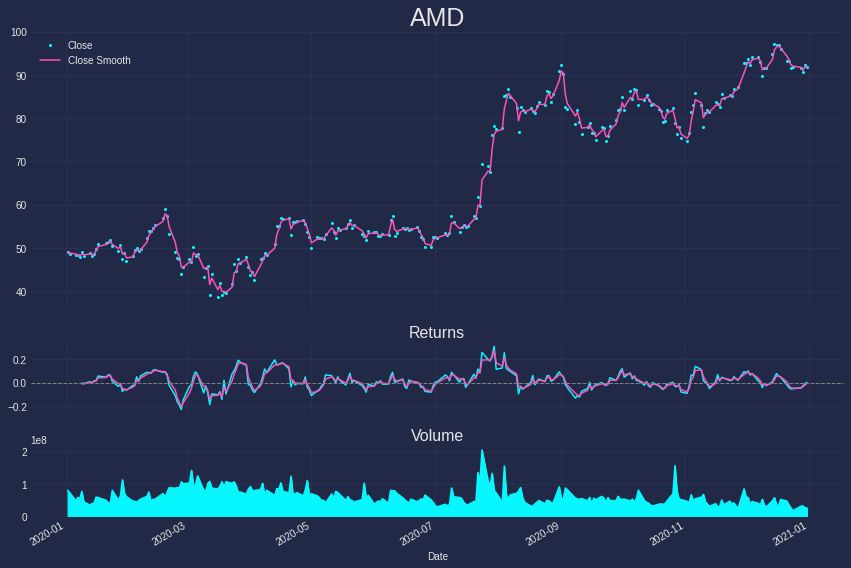

In [142]:
fig, axs = plt.subplots(figsize=(12, 8), nrows=3, sharex=True,
                        gridspec_kw={'height_ratios':[4,1,1]})

## Prices and smoothed prices.
ax = axs[0]
stock_df['Close'].plot(ax=ax, ls='', marker='o', markersize=2, label='Close')
stock_df['Close_Smooth'].plot(ax=ax, ls='-', markersize=2, label='Close Smooth')
ax.legend()
ax.set_title(ticker, size=25)

## Some indicator.
ax = axs[1]
stock_df['ret'].plot(ax=ax)
stock_df['ret_smooth'].plot(ax=ax)
ax.set_title('Returns', size=16)
ax.axhline(0, ls='--', lw=1, c='grey')

## Volume.
ax = axs[2]
stock_df['Volume'].plot.area(ax=ax)
ax.set_title('Volume', size=16)

fig.tight_layout();

## Random Forest

In [143]:
## Create model input data.
feats = stock_df.columns[17:].tolist()
print(len(feats))

model_df = stock_df[feats + ['Close', 'Close_Smooth', 'ret',
                             'ret_smooth','ret_type_smooth']].dropna()

## Divide dataset.
train_range = np.arange(0, np.ceil(model_df.shape[0] * 0.8))
test_range = np.arange(train_range[-1]+1, model_df.shape[0])

train_df = model_df.iloc[train_range]
test_df = model_df.iloc[test_range]

9


In [144]:
## Train model and evaluate.
clf = RandomForestClassifier(n_estimators=10, random_state=42, 
                             n_jobs=-1)

clf.fit(train_df[feats], train_df['ret_type_smooth'])

train_pred = clf.predict(train_df[feats])
test_pred = (clf.predict_proba(test_df[feats])[:, 1] > 0.5).astype(float)

print('Training results:\n',
      confusion_matrix(train_df['ret_type_smooth'], train_pred))

print('Test accuracy:\n',
      confusion_matrix(test_df['ret_type_smooth'], test_pred))

Training results:
 [[95  0]
 [ 0 89]]
Test accuracy:
 [[18  2]
 [16  9]]


TRAINING:
Buy & hold return: 11.324
Max return: 3.739
Actual return: 3.739

TEST:
Buy & hold return: 0.724
Max return: 1.348
Actual return: 0.306


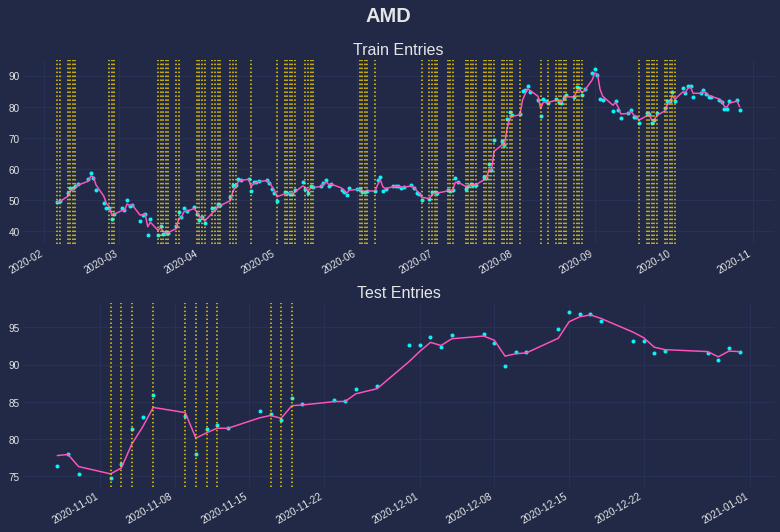

In [145]:
## Evaluate and plot returns.
fig, axs = plt.subplots(figsize=(11, 7), nrows=2, sharey=False)

ax = axs[0]
train_df['Close'].plot(ax=ax, ls='', marker='o', markersize=3)
train_df['Close_Smooth'].plot(ax=ax)
[ax.axvline(v, c=colors[2], ls=':') for v in
 train_df.loc[train_pred.astype(bool)].index]
ax.set_title('Train Entries', size=16)
ax.set_xlabel('')

print('TRAINING:')
print('Buy & hold return:', (((1 + train_df['ret']).cumprod() - 1).tail(1).values[0].round(3)))
print('Max return:', (train_df['ret'].shift(-1) * train_df['ret_type_smooth']).sum().round(3))
print('Actual return:', (train_df['ret'].shift(-1) * train_pred).sum().round(3))

## Test.
ax = axs[1]
test_df['Close'].plot(ax=ax, ls='', marker='o', markersize=3)
test_df['Close_Smooth'].plot(ax=ax)
[ax.axvline(v, c=colors[2], ls=':') for v in
 test_df.loc[test_pred.astype(bool)].index]
ax.set_title('Test Entries', size=16)
ax.set_xlabel('')


fig.tight_layout()
fig.suptitle(ticker, y=1.05, size=20, weight='bold')

print('\nTEST:')
print('Buy & hold return:', (test_df['ret']).sum().round(3))
print('Max return:', (test_df['ret'].shift(-ret_lag) * test_df['ret_type_smooth']).sum().round(3))
print('Actual return:', (test_df['ret'].shift(-ret_lag) * test_pred).sum().round(3))

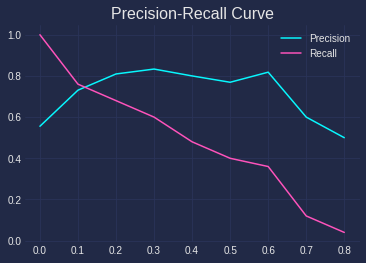

In [146]:
precision, recall, treshold = precision_recall_curve(test_df['ret_type_smooth'],
                                                     clf.predict_proba(test_df[feats])[:, 1])

# Plot the output.
fig, ax = plt.subplots()
ax.plot(treshold, precision[:-1],  label='Precision')
ax.plot(treshold, recall[:-1], label='Recall')
ax.legend()
ax.set_title('Precision-Recall Curve', size=16);

## Feature Importance

In [147]:
pd.DataFrame(zip(feats, clf.feature_importances_)).sort_values(1, ascending=False)

,0,1
7,obv,0.261016
8,obv_ret,0.150773
6,ret_acorr_smooth,0.128127
1,close_err_std,0.108798
2,ret_rank_smooth,0.090837
3,ret_mom_smooth,0.080459
5,hl_diff,0.077912
4,oc_diff,0.059854
0,close_err,0.042225


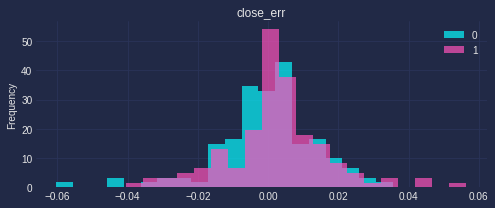

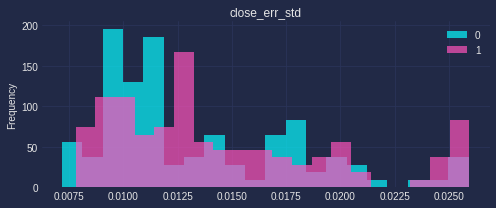

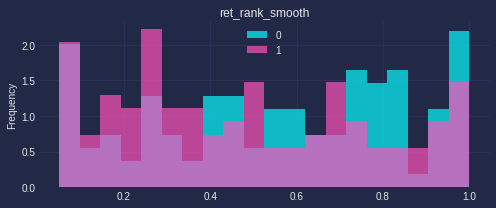

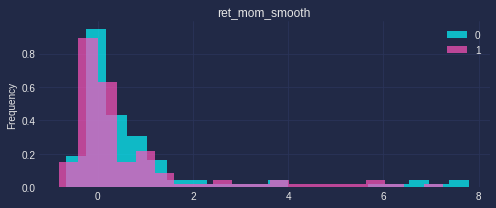

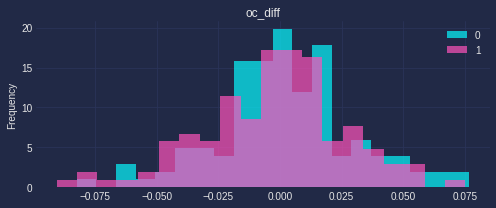

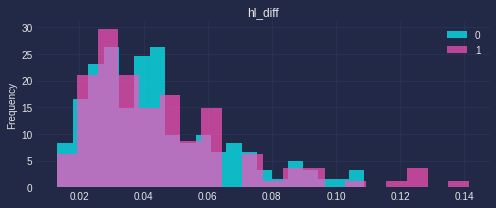

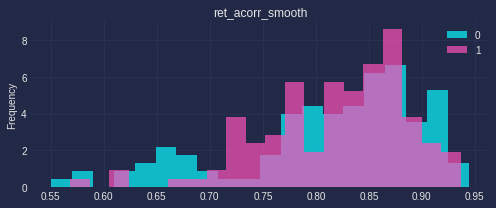

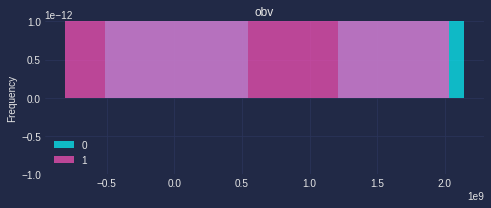

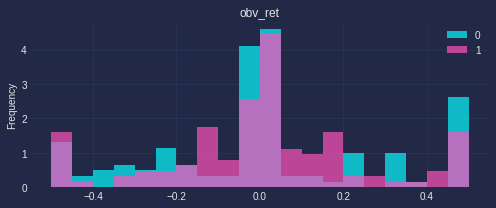

In [148]:
for feat in feats:
  fig, ax = plt.subplots(figsize=(7,3))
  stock_df.groupby('ret_type_smooth')[feat].plot.hist(bins=rank_roll, alpha=0.7,
                                                      ax=ax, density=True)
  ax.set_title(feat)
  ax.legend()
  fig.tight_layout();